# <center>Brain tumor classification using convolutional neural networks<center>


## Generic library imports

In [1]:
#Base imports
import sys
import os
import pathlib
import importlib # for reloading local class 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline


## Check notebook environment 
- Runtime environment: Google Colab or local
- Setup paths for reading datasets and saving outputs (models, figures, etc)
    - If in *Colab Environment* copy to the running machine from Google Drive
        - datafiles
        - `btc_helpers.py` python file for importing helper classes and functions
- Check availability of CPU/GPU/TPU and get the `strategy` to use for running models


In [5]:
# output folder and file prefix
outputSubfolder = 'btc_cnn'  # easy to manage if you create a subfoder under output
saveFilePrefix = 'btc_cnn_'  # need the 2 underscores for subsequent parsing of attributes ffrom filename 

##----------Check colab environment---------##
colabEnv = False
try:
    from google.colab import drive
    colabEnv=True
    drive.mount('/content/drive')
    print('In Google Colab environment. Mounted drive at /content/drive/MyDrive')
except:
    print('Not in Google Colab environment')
    
##--------------Setup paths----------------##
if colabEnv:
    # make a directory at current working directorys
    pathlib.Path('DataSetBrainTumor').mkdir(parents=True,exist_ok=True)
    # Only copy cdatasets converted to HDF5 files to host drive
    !cp /content/drive/MyDrive/ColabData/07-Capstone/DataSetBrainTumor/*.h5 DataSetBrainTumor/   
    !cp -R /content/drive/MyDrive/DataSciProjects/GL-IDSS-ADSB/07-Capstone/btc .
    
    # Setup Paths for reading dataset and creating output (Google Drive)
    dataPath = "./DataSetBrainTumor"
    outputPath = '/content/drive/MyDrive/MIT-IDSS-Capstone/07-Capstone/notebooks/output'
else:
    # Setup Paths for reading dataset and creating output
    dataPath = '../DataSetBrainTumor' # dir or link to dir for running local
    outputPath = './output' # dir or link to dir (usually under the location of current notebook)

outputPath = os.path.join(outputPath,outputSubfolder)
# Output path for figures, models, and model-tuning
modelPath = os.path.join(outputPath,'models')
figurePath = os.path.join(outputPath,'figures')
modelTunerPath = os.path.join(outputPath,'model-tuner')

# Create output paths if not exist
pathlib.Path(modelPath).mkdir(parents=True,exist_ok=True)
pathlib.Path(figurePath).mkdir(parents=True,exist_ok=True)
pathlib.Path(modelTunerPath).mkdir(parents=True,exist_ok=True)

# add functions to create save-filenames
def getFigurePath(fn):
    return os.path.join(figurePath, saveFilePrefix + fn)

def getModelPath(fn):
    return os.path.join(modelPath, saveFilePrefix + fn)

def getModelTunerPath(fn):
    return os.path.join(modelTunerPath, saveFilePrefix + fn)
    
# print data location and files:
print(f'\nContents of data folder [{dataPath}]')
print(os.listdir(dataPath))
# print python src location and files:
print(f'\nContents of python source folder [btc]')
print(os.listdir('btc'))
# print output folder locations
print(f'\nOutput folders [{outputPath}]')
print(os.listdir(outputPath))
print(f'\nPrefix for all saved files {saveFilePrefix}')
print()


Not in Google Colab environment

Contents of data folder [../DataSetBrainTumor]
['Training_256.h5', 'Training_150.h5', 'readme.txt~', 'Training', 'Testing', 'readme.txt', 'Testing_256.h5', 'Testing_150.h5']

Contents of python source folder [btc]
['.DS_Store', 'test_btc_DataUtils.py', '__init__.py', '__pycache__', 'btc_helpers.py']

Output folders [./output/btc_cnn]
['models', 'model-tuner', 'figures']

Prefix for all saved files btc_cnn_



In [170]:
import btc.btc_helpers as btc

strategy = btc.getCPUorGPUorTPUStrategy()


Running on CPU


In [176]:
importlib.reload(btc)
dataUtil = btc.DataUtil(dataPath,'Training','Testing')
imgSize=256
trainArr,testarr,trainDf,testDf = dataUtil.getTrainTestData(imgSize)
labelDistributionDf = btc.getLabelDistributionDf({'train':trainDf['tumorCategory'],'test':testDf['tumorCategory']})
display(labelDistributionDf.apply(btc.decimal_format,precision=.1))

Updating cache with training and testing datasets
Caching train and test datasets
Reading HDF5 file ../DataSetBrainTumor/Training_256.h5
Reading HDF5 file ../DataSetBrainTumor/Testing_256.h5
Returning cached [Original] training and testing datasets


,train,train%,test,test%
glioma,829.0,28.8,100.0,24.9
meningioma,830.0,28.8,115.0,28.6
no_tumor,395.0,13.7,113.0,28.1
pituitary,827.0,28.7,74.0,18.4
Total,2881.0,100.0,402.0,100.0


In [171]:
importlib.reload(btc)
# Run local so that the HDF5 file is generated, 
# On Colab it will take a long time unless the data folders are copied to the remote host

# trainArr,testarr,trainDf,testDf = dataUtil.getTrainTestData(150,mergeSplit='all')
# display(btc.getLabelDistributionDf({'train':trainDf['tumorCategory'],'test':testDf['tumorCategory']}))

    
trainDf.describe(include='all').apply(btc.decimal_format,precision=.1)


,tumorCategory,fileId,origWidth,origHeight,cropWidth,cropHeight,setName,imageUID
count,2881.0,2881.0,2881.0,2881.0,2881.0,2881.0,2881.0,2881.0
unique,4.0,2881.0,nan,nan,nan,nan,1.0,2881.0
top,meningioma,m3 (41).jpg,nan,nan,nan,nan,Training,Training_glioma_gg (523).jpg
freq,830.0,1.0,nan,nan,nan,nan,2881.0,1.0
mean,nan,nan,481.2,479.7,427.1,378.5,nan,nan
std,nan,nan,103.2,110.4,100.5,100.5,nan,nan
min,nan,nan,198.0,180.0,143.0,118.0,nan,nan
25%,nan,nan,512.0,512.0,397.0,334.0,nan,nan
50%,nan,nan,512.0,512.0,450.0,381.0,nan,nan
75%,nan,nan,512.0,512.0,479.0,432.0,nan,nan


3.2.2


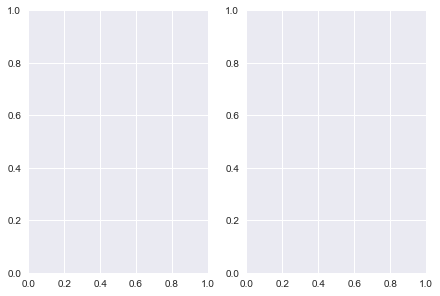

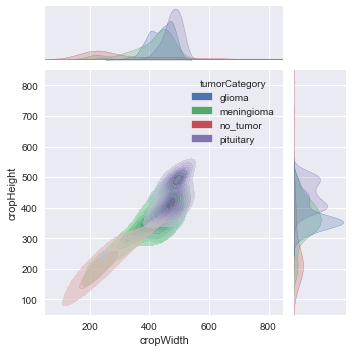

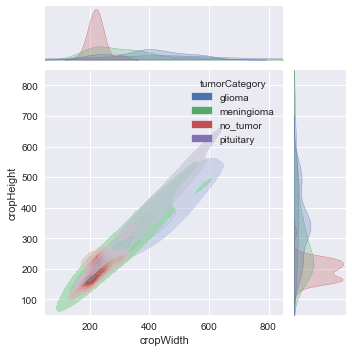

In [131]:
importlib.reload(btc)

btc.plotPieDistribution(trainDf,testDf,getFigurePath('pieDistribution.png'))
btc.plotAspect(trainDf,testDf,xyCols=['origWidth','origHeight'],lims=[50,850],figFile=getFigurePath('aspectOriginal.png'))
btc.plotAspect(trainDf,testDf,xyCols=['cropWidth','cropHeight'],lims=[50,850],figFile=getFigurePath('aspectCropped.png'))


sns.jointplot(x='cropWidth', y='cropHeight', hue='tumorCategory',data=testDf, 
                      size=5, ratio=4,kind='kde',fill=True,alpha=0.6,
                      xlim=[50,850],ylim=[50,850])



In [130]:
gs[1].get_gridspec
!pip3 install --upgrade matplotlib
!pip3 install --upgrade seaborn==0.11.1

print(sns.__version__)

Requirement already up-to-date: matplotlib in /Users/subravcr/opt/anaconda3/envs/dataSci/lib/python3.7/site-packages (3.3.4)
Requirement already up-to-date: seaborn==0.11.1 in /Users/subravcr/opt/anaconda3/envs/dataSci/lib/python3.7/site-packages (0.11.1)
0.11.0


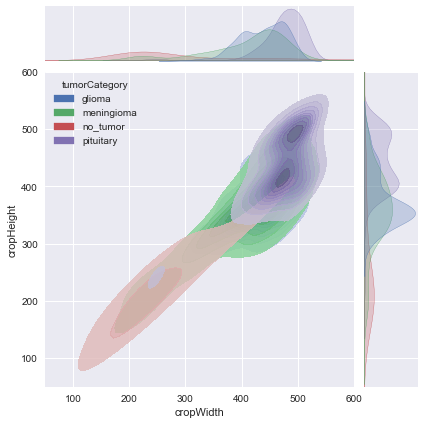

,tumorCategory,fileId,origWidth,origHeight,cropWidth,cropHeight,setName,imageUID
0,glioma,gg (362).jpg,512,512,429.0,382.0,Training,Training_glioma_gg (362).jpg
1,glioma,gg (698).jpg,512,512,430.0,328.0,Training,Training_glioma_gg (698).jpg
2,glioma,gg (732).jpg,512,512,402.0,341.0,Training,Training_glioma_gg (732).jpg
3,glioma,gg (227).jpg,512,512,484.0,466.0,Training,Training_glioma_gg (227).jpg
4,glioma,gg (677).jpg,512,512,499.0,358.0,Training,Training_glioma_gg (677).jpg
...,...,...,...,...,...,...,...,...
2876,pituitary,p (663).jpg,512,512,462.0,402.0,Training,Training_pituitary_p (663).jpg
2877,pituitary,p (399).jpg,512,512,475.0,451.0,Training,Training_pituitary_p (399).jpg
2878,pituitary,p (233).jpg,512,512,476.0,452.0,Training,Training_pituitary_p (233).jpg
2879,pituitary,p (726).jpg,512,512,424.0,387.0,Training,Training_pituitary_p (726).jpg


In [77]:

g = sns.jointplot(data=trainDf,x='cropWidth',y='cropHeight',hue='tumorCategory',
                  kind='kde',fill=True,alpha=0.8,
                  xlim=[50, 600],ylim=[50,600])
g.ax_joint.legend_._loc=2
plt.show()
trainDf

In [72]:
g.ax_joint.legend_._loc=2



In [20]:
# Check previous reports for validation / classification
importlib.reload(btc)

prevModelPath = './prevOutput/models/f6'
prevModelBaseFile = 'final_06_'

historyDf,classifDf = btc.getAggregatedReportsDf(prevModelPath,prevModelBaseFile)



In [41]:
historyDf['BN'] = [1 if x.find('BatchNorm') > -1 else 0 for x in historyDf['modelName']]
historyDf['L2R'] = [1 if x.find('L2Regularize') > -1 else 0 for x in historyDf['modelName']]
historyDf['DROP'] = [1 if x.find('Dropout') > -1 else 0 for x in historyDf['modelName']]


historyDf

,epoch,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall,fileId,modelName,imgPreProc,BN,L2R,DROP
0,0,1.326753,0.340712,0.424837,0.028212,1.293279,0.462738,0.000000,0.000000,final_06_BaseModel-L2Regularize-ZScore_history...,BaseModel-L2Regularize,ZScore,0,1,0
1,1,1.066344,0.524740,0.651163,0.291667,1.045492,0.603120,0.781250,0.129983,final_06_BaseModel-L2Regularize-ZScore_history...,BaseModel-L2Regularize,ZScore,0,1,0
2,2,0.883796,0.619358,0.687500,0.496528,0.903061,0.665511,0.796813,0.346620,final_06_BaseModel-L2Regularize-ZScore_history...,BaseModel-L2Regularize,ZScore,0,1,0
3,3,0.769388,0.680122,0.736645,0.598524,0.825180,0.750433,0.888446,0.386482,final_06_BaseModel-L2Regularize-ZScore_history...,BaseModel-L2Regularize,ZScore,0,1,0
4,4,0.683302,0.726562,0.765270,0.657986,0.728762,0.807626,0.882698,0.521664,final_06_BaseModel-L2Regularize-ZScore_history...,BaseModel-L2Regularize,ZScore,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,17,0.242152,1.000000,1.000000,1.000000,0.671028,0.880416,0.884615,0.876950,final_06_BaseModel-BatchNorm-L2Regularize-Drop...,BaseModel-BatchNorm-L2Regularize-Dropout,CLAHE,1,1,1
18,18,0.238833,1.000000,1.000000,1.000000,0.650842,0.882149,0.883478,0.880416,final_06_BaseModel-BatchNorm-L2Regularize-Drop...,BaseModel-BatchNorm-L2Regularize-Dropout,CLAHE,1,1,1
19,19,0.235412,1.000000,1.000000,1.000000,0.673063,0.880416,0.884211,0.873484,final_06_BaseModel-BatchNorm-L2Regularize-Drop...,BaseModel-BatchNorm-L2Regularize-Dropout,CLAHE,1,1,1
20,20,0.231493,1.000000,1.000000,1.000000,0.664348,0.880416,0.881119,0.873484,final_06_BaseModel-BatchNorm-L2Regularize-Drop...,BaseModel-BatchNorm-L2Regularize-Dropout,CLAHE,1,1,1


In [48]:
historyDf.groupby(['modelName','imgPreProc']).max('epoch')


epoch          loss  \
modelName                                imgPreProc                         
BaseModel                                CLAHE           27  1.220231e+00   
                                         HistEqual       22  1.224735e+00   
                                         Laplacian       28  1.355016e+00   
                                         Normalize       26  1.191910e+00   
                                         Raw             29  2.544031e+00   
                                         Scaled          26  1.209339e+00   
                                         ZScore          17  1.015708e+00   
BaseModel-BatchNorm                      CLAHE           21  1.224675e+00   
                                         HistEqual       36  1.273157e+00   
                                         Laplacian       25  1.343241e+00   
                                         Normalize       25  1.160428e+00   
                                         Raw             23  1.525532e+00   
                                         Scaled          28  1.232864e+00   
                                         ZScore          18  9.857188e-01   
BaseModel-BatchNorm-L2Regularize         CLAHE           22  1.419310e+00   
                                         HistEqual       32  1.502016e+00   
                                         Laplacian       36  1.587111e+00   
                                         Normalize       27  1.447582e+00   
                                         Raw             23  1.638473e+00   
                                         Scaled          25  1.408349e+00   
                                         ZScore          23  1.314481e+00   
BaseModel-BatchNorm-L2Regularize-Dropout CLAHE           21  1.114069e+00   
                                         HistEqual       16  1.083392e+00   
                                         Laplacian       13  1.283239e+00   
                                         Normalize       14  1.172638e+00   
                                         Raw             19  1.156007e+00   
                                         Scaled          31  1.100118e+00   
                                         ZScore          36  1.123052e+00   
BaseModel-Dropout                        CLAHE           25  8.496851e-01   
                                         HistEqual       15  8.528260e-01   
                                         Laplacian       19  9.817938e-01   
                                         Normalize       27  8.109514e-01   
                                         Raw             28  8.657749e-01   
                                         Scaled          16  8.407724e-01   
                                         ZScore          13  8.562146e-01   
BaseModel-L2Regularize                   CLAHE           41  1.340840e+00   
                                         HistEqual       43  1.344633e+00   
                                         Laplacian        8  1.375440e+00   
                                         Normalize       47  1.331775e+00   
                                         Raw             44  9.437800e+00   
                                         Scaled          33  1.324332e+00   
                                         ZScore          36  1.326753e+00   
BaseModelNew                             categorical      5  1.397638e+10   
                                         kl               5  1.315191e+01   
                                         mean             5  3.574219e-01   

                                                      accuracy  precision  \
modelName                                imgPreProc                         
BaseModel                                CLAHE        1.000000   1.000000   
                                         HistEqual    1.000000   1.000000   
                                         Laplacian    1.000000   1.000000   
                                         Normaliz

In [26]:
from pandas.plotting import parallel_coordinates



,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


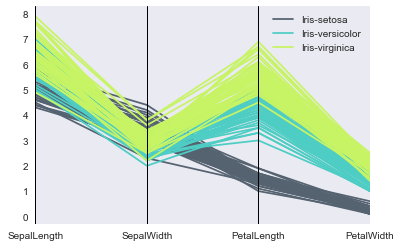

In [29]:
df = pd.read_csv('https://raw.github.com/pandas-dev/pandas/master/pandas/tests/io/data/csv/iris.csv')
pd.plotting.parallel_coordinates( df, 'Name', color=('#556270', '#4ECDC4', '#C7F464'))
df.head()

In [38]:
import plotly.graph_objects as go
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())
#dataDf = pd.read_json(url)
# datasDf.head()
#print(response.readline())
data

{'data': [{'type': 'sankey',
   'domain': {'x': [0, 1], 'y': [0, 1]},
   'orientation': 'h',
   'valueformat': '.0f',
   'valuesuffix': 'TWh',
   'node': {'pad': 15,
    'thickness': 15,
    'line': {'color': 'black', 'width': 0.5},
    'label': ["Agricultural 'waste'",
     'Bio-conversion',
     'Liquid',
     'Losses',
     'Solid',
     'Gas',
     'Biofuel imports',
     'Biomass imports',
     'Coal imports',
     'Coal',
     'Coal reserves',
     'District heating',
     'Industry',
     'Heating and cooling - commercial',
     'Heating and cooling - homes',
     'Electricity grid',
     'Over generation / exports',
     'H2 conversion',
     'Road transport',
     'Agriculture',
     'Rail transport',
     'Lighting & appliances - commercial',
     'Lighting & appliances - homes',
     'Gas imports',
     'Ngas',
     'Gas reserves',
     'Thermal generation',
     'Geothermal',
     'H2',
     'Hydro',
     'International shipping',
     'Domestic aviation',
     'Internation

In [23]:
# sanky with ployly
#https://plotly.com/python/sankey-diagram/
import plotly.graph_objects as go
import urllib, json

url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())
dataOri = data.copy()
# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
                                    for src in data['data'][0]['link']['source']]

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = "TWh",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label'],
      color =  data['data'][0]['link']['color']
))])

fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
                  font_size=10)
fig.show()

In [24]:
dataOri


{'data': [{'type': 'sankey',
   'domain': {'x': [0, 1], 'y': [0, 1]},
   'orientation': 'h',
   'valueformat': '.0f',
   'valuesuffix': 'TWh',
   'node': {'pad': 15,
    'thickness': 15,
    'line': {'color': 'black', 'width': 0.5},
    'label': ["Agricultural 'waste'",
     'Bio-conversion',
     'Liquid',
     'Losses',
     'Solid',
     'Gas',
     'Biofuel imports',
     'Biomass imports',
     'Coal imports',
     'Coal',
     'Coal reserves',
     'District heating',
     'Industry',
     'Heating and cooling - commercial',
     'Heating and cooling - homes',
     'Electricity grid',
     'Over generation / exports',
     'H2 conversion',
     'Road transport',
     'Agriculture',
     'Rail transport',
     'Lighting & appliances - commercial',
     'Lighting & appliances - homes',
     'Gas imports',
     'Ngas',
     'Gas reserves',
     'Thermal generation',
     'Geothermal',
     'H2',
     'Hydro',
     'International shipping',
     'Domestic aviation',
     'Internation